In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [39]:
path = 'data/data.csv'
data = pd.read_csv(path)
normalized_pctg_change = data['normalized_percent_change'] # Save variable fot later use in model
data.drop(columns=['normalized_percent_change'], inplace=True)

In [40]:
# Proportion of zeros in the database
normalized_pctg_change[normalized_pctg_change == 0.00].count()/normalized_pctg_change.count()

0.7488943488943489

In [41]:
xgboost_df = data.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1] # Shape is rows x features (38)
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
random_state = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = xgb.DMatrix(X_train, y_train, label=y_train)
d_test = xgb.DMatrix(X_test, y_test, label=y_test)
best_params = {
    # Classification
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 0.1, # L1 regularization
    'lambda': 1, # L2 regularization
    'learning_rate': 0.1, 
    'max_depth': 7,
    'tree_method': 'hist', 
    'device': "cuda",
}
num_boost_round = 700
regression_params_short = {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 28/08/2024. Range (0,1)
regression_params_long = {'alpha': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 01/09/2024. Range (-1,1) Decreases coverage in Jackknife+ by 0.02
binary_params = {'alpha': 0, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 800, "eval_metric": 'auc', 'objective': 'binary:logistic', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda",} 

d_all = xgb.DMatrix(X)
model = xgb.train(best_params, d_train, num_boost_round=num_boost_round, evals=((d_test, "test"),),verbose_eval=False, early_stopping_rounds=10)
y_pred_proba_all = model.predict(d_all, iteration_range=(0, model.best_iteration + 1))
y_pred_all = (y_pred_proba_all > 0.5).astype(int)

In [42]:
def split_into_five_equal_parts(X, y_binary, y_continuous, random_state=42):
    """
    Split data into 5 equal parts, maintaining alignment between binary and continuous outcomes
    
    Parameters:
    -----------
    X : features DataFrame
    y_binary : binary outcome (change/no change in LEDD)
    y_continuous : continuous outcome (normalized percentage change)
    random_state : for reproducibility
    
    Returns:
    --------
    Training, calibration, and test sets for both binary and continuous outcomes
    """
    # First split: 20% for test set, 80% remaining -> Test
    X_temp, X_test, y_binary_temp, y_binary_test, y_cont_temp, y_cont_test = train_test_split(
        X, y_binary, y_continuous, test_size=0.2, random_state=random_state
    )
    
    # Splits 75% of the 80%, which leaves one set with 20% and another with 60% -> Train
    X_train, X_temp2, y_binary_train, y_binary_temp2, y_cont_train, y_cont_temp2 = train_test_split(
        X_temp, y_binary_temp, y_cont_temp, test_size=0.75, random_state=random_state
    )
    
    # Splits 66% of the 60%, which leaves one set with 20% and another with 40% -> Calib1
    X_calib1, X_temp3, y_binary_calib1, y_binary_temp3, y_cont_calib1, y_cont_temp3 = train_test_split(
        X_temp2, y_binary_temp2, y_cont_temp2, test_size=0.5, random_state=random_state
    )

    # Splits 50% of the 40%, which leaves two sets with 20% each -> Calib2 and Calib3
    X_calib2, X_calib3, y_binary_calib2, y_binary_calib3, y_cont_calib2, y_cont_calib3 = train_test_split(
        X_temp3, y_binary_temp3, y_cont_temp3, test_size=0.5, random_state=random_state
    )
    
    return (
        X_train, X_calib1, X_calib2, X_calib3, X_test,
        y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
        y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test
    )

## Conformal Prediction Happens Here:

### Initial Version:
Uses three calibration sets. Calibration set 1 is used to find alpha_r. Calibration set 2 is used entirely for beta_hat. Calibration set 3 is used for the interval_width. R optimization used data from multiple calibration sets which (could) violates the assumption of exchangeability. beta_hat is calculated without any adjustment.

Shows the weakest theoretical guarantee (violates exchangeability) with generally smallest but less reliable intervals

In [43]:
# Initial Version
def conformal_prediction_zero_inflated(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test, 
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(X, y_binary, y_continuous)
    
    # Train classification model on binary outcome
    classifier = xgb.XGBClassifier(**binary_params)
    # Fit classifier with binary outcome (change/no change in LEDD)
    classifier.fit(X_train, y_binary_train)
    # Get predicted probabilities for class one[:,] (change in LEDD) from the first calibration set
    # These probabilities will be used to calculate alpha_r
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Train regression model on non-zero continuous outcomes
    # Use mask to filter out patients with no change in LEDD or whose predicted probabily of change is minimal
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    # Fit regressor with continuous outcome (normalized percentage change)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # print(f'First calibration dataset{probs_calib1, probs_calib1}')
    # Try different values of r to optimize intervals
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    # Report
    # X amount of data is below alpha_r
    for r in r_values:
        # Find quantiles for predicted probabilities
        alpha_r = np.quantile(probs_calib1, r)
        # print(f'alpha_r: {alpha_r}')

        # Second calibration set: Calculate beta_hat and accuracy of zero predictions
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1] # Predicted probabilities for the secnd calibration set
        pred_zeros = probs_calib2 <= alpha_r # Predicted probabilities less than or equal to alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0) # Accuracy of zero predictions (propotion of correct zero predictions) proportion of true zeros among predicted zerps
        # print(f'beta_hat: {beta_hat}')
        # Calculate final quantile for interval width
        # beta_hat * r coverage ww aleady achieved. 1-r is a fraction of the nonzero data
        if np.isnan(beta_hat):
            continue

        if beta_hat < alpha_tilda:
            # If classification performance is poor, use VCI
            y_pred_calib3 = regressor.predict(X_calib3)
            residuals = np.abs(y_cont_calib3 - y_pred_calib3)
            interval_width = np.quantile(residuals, alpha_tilda)
            all_interval_lengths.append((r, interval_width, alpha_r, False))  # False flag for VCI
        else:     
            final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
            if final_quantile < 0:
                    final_quantile = alpha_tilda
            if final_quantile > 1:
                continue
            
            # A: Prob of true value being zero
            # B: Model predict this point as zero
            # Third calibration set: Calculate interval width
            probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
            nonzero_mask = probs_calib3 > alpha_r
            if not any(nonzero_mask):
                continue
            
            y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
            residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero) # True vs Predicted
            interval_width = np.quantile(residuals, final_quantile) #* (1 - r) # We choose the quantile of the predicted residuals
            all_interval_lengths.append((r, interval_width, alpha_r, True)) # Average int_width = interval_width*(1 - r)
            # Calibration set 2 for the r
            nonzero_coverage = np.mean((y_test[nonzero_mask] >= lower_bound[nonzero_mask]) & 
                                     (y_test[nonzero_mask] <= upper_bound[nonzero_mask]))
            nonzero_width = np.mean(upper_bound[nonzero_mask] - lower_bound[nonzero_mask])

        # Optimal r only uses calibration 2. FIrst part of cal r, other for b hat, threshold and quantile. And then the interval length
        # I need to modify the approach in my current code. Now calibration 2 will be futher divided into 2 parts. The first part will be used to find the optimal r. The second part will be used for b_hat, threshold and quantile.
        #      r now will have nothing to do with the third calibration set because it is violating the principle of exchangaebility.
    if not all_interval_lengths:
        raise ValueError("No valid intervals found")
    
    # Choose best r value and corresponding width
    best_r, best_width, best_alpha_r, is_cpci = min(all_interval_lengths, key=lambda x: x[1])
    # Get beta_hat for best r
    probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
    pred_zeros = probs_calib2 <= best_alpha_r
    best_beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)

    # Make predictions on test set
    test_pred = regressor.predict(X_test)

    if is_cpci:
        # Use CPCI Approach
            test_probs = classifier.predict_proba(X_test)[:, 1]
            nonzero_mask = test_probs > best_alpha_r
                # Create prediction intervals
            lower_bound = np.zeros_like(test_pred)
            upper_bound = np.zeros_like(test_pred)
    
            lower_bound[nonzero_mask] = test_pred[nonzero_mask] - best_width
            upper_bound[nonzero_mask] = test_pred[nonzero_mask] + best_width
    else:
        # Use VCI Approach
        lower_bound = test_pred - best_width
        upper_bound = test_pred + best_width
    
    return lower_bound, upper_bound, y_cont_test

### Version 1
Uses 3 calibration sets but further slipts calibration set 1 into two parts: The first half used to find alpha_r, second half used to calculate beta_hat and evaluate intervals which provides better exchangeability guarantees. Still uses calibration sets 2 and 3 for the final interval width. The split enables proper r optimization within a single calibration set. Defaults to Vanilla Conformal if beta_hat < alpha_tilda.

Maintains exchangeability with providing moderate interval width.

In [293]:
# Version 1: Proper split of calibration set 1
def conformal_prediction_zero_inflated_v1(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test, 
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
         X, y_binary, y_continuous)
    
    # Split calibration set one for r optimization
    split_index = len(X_calib1) // 2
    X_calib1_first = X_calib1[:split_index]
    X_calib1_second = X_calib1[split_index:]
    y_binary_calib1_first = y_binary_calib1[:split_index]
    y_binary_calib1_second = y_binary_calib1[split_index:]
    y_cont_calib1_first = y_cont_calib1[:split_index]
    y_cont_calib1_second = y_cont_calib1[split_index:]
    
    # Train models
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # Find optimal r using split calibration set one
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    for r in r_values:
        # Use first half for alpha_r
        probs_first = classifier.predict_proba(X_calib1_first)[:, 1]
        alpha_r = np.quantile(probs_first, r)
        
        # Use second half for beta_hat and intervals
        probs_second = classifier.predict_proba(X_calib1_second)[:, 1]
        pred_zeros = probs_second <= alpha_r
        beta_hat = np.mean(y_binary_calib1_second[pred_zeros] == 0)
        
        if np.isnan(beta_hat):
            continue
            
        if beta_hat < alpha_tilda:
            # Use VCI
            y_pred = regressor.predict(X_calib1_second)
            residuals = np.abs(y_cont_calib1_second - y_pred)
            interval_width = np.quantile(residuals, alpha_tilda)
            all_interval_lengths.append((r, interval_width, alpha_r, False))
        else:
            # Use CPCI
            final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
            if final_quantile < 0:
                final_quantile = alpha_tilda
            if final_quantile > 1:
                continue
                
            nonzero_mask = probs_second > alpha_r
            if not any(nonzero_mask):
                continue
                
            y_pred_nonzero = regressor.predict(X_calib1_second[nonzero_mask])
            residuals = np.abs(y_cont_calib1_second[nonzero_mask] - y_pred_nonzero)
            interval_width = np.quantile(residuals, final_quantile)
            all_interval_lengths.append((r, interval_width, alpha_r, True))
    
    # Get best r and run full pipeline
    best_r, best_width, best_alpha_r, is_cpci = min(all_interval_lengths, key=lambda x: x[1])
    
    # Re-run with full calibration sets
    if is_cpci:
        # Get new alpha_r with full calib1
        probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
        alpha_r = np.quantile(probs_calib1, best_r)
        
        # Check beta_hat with calib2
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
        pred_zeros = probs_calib2 <= alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
        
        if beta_hat < alpha_tilda:
            # Fallback to VCI
            y_pred_calib3 = regressor.predict(X_calib3)
            residuals = np.abs(y_cont_calib3 - y_pred_calib3)
            interval_width = np.quantile(residuals, alpha_tilda)
            is_cpci = False
        else:
            # Use CPCI with calib3
            final_quantile = (alpha_tilda - beta_hat * best_r) / (1 - best_r)
            probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
            nonzero_mask = probs_calib3 > alpha_r
            y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
            residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero)
            interval_width = np.quantile(residuals, final_quantile)
    
    # Make predictions on test set
    test_pred = regressor.predict(X_test)
    
    if is_cpci:
        test_probs = classifier.predict_proba(X_test)[:, 1]
        nonzero_mask = test_probs > alpha_r
        lower_bound = np.zeros_like(test_pred)
        upper_bound = np.zeros_like(test_pred)
        lower_bound[nonzero_mask] = test_pred[nonzero_mask] - interval_width
        upper_bound[nonzero_mask] = test_pred[nonzero_mask] + interval_width
    else:
        lower_bound = test_pred - interval_width
        upper_bound = test_pred + interval_width
    
    return lower_bound, upper_bound, y_cont_test

### V1 with beta tilde (current version)
Same split for calibration 1. Key difference is the introduction of beta_tilde where c=0.1. The final_quantile uses beta_tilde instead of beta_hat. The adjustment term (0.1 * sqrt(log(n)/n)) gets smaller as n increases. It also provides better finite-sample guarantees.

Provides strongest exchangeability with finite sample guarantees with slightly wider intervals but better coverage guarantees

In [44]:
# V1 with beta tilde (current version): Split + beta_tilde adjustment
def conformal_prediction_zero_inflated_v1(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
         X, y_binary, y_continuous)
    
    # Split calibration set 1
    split_index = len(X_calib1) // 2
    X_calib1_first = X_calib1[:split_index]
    X_calib1_second = X_calib1[split_index:]
    y_binary_calib1_first = y_binary_calib1[:split_index]
    y_binary_calib1_second = y_binary_calib1[split_index:]
    y_cont_calib1_first = y_cont_calib1[:split_index]
    y_cont_calib1_second = y_cont_calib1[split_index:]
    
    # Train models
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # Get probabilities
    probs_calib1_first = classifier.predict_proba(X_calib1_first)[:, 1]
    
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    for r in r_values:
        alpha_r = np.quantile(probs_calib1_first, r)
        
        # Calculate beta_hat and beta_tilde
        probs_calib1_second = classifier.predict_proba(X_calib1_second)[:, 1]
        pred_zeros = probs_calib1_second <= alpha_r
        beta_hat = np.mean(y_binary_calib1_second[pred_zeros] == 0)
        
        n = len(pred_zeros)
        beta_tilde = beta_hat - 0.1 * np.sqrt(np.log(n)/n)  # Added beta_tilde adjustment
        
        if np.isnan(beta_tilde):
            continue
            
        if beta_tilde < alpha_tilda:
            # Use VCI
            y_pred_calib3 = regressor.predict(X_calib3)
            residuals = np.abs(y_cont_calib3 - y_pred_calib3)
            interval_width = np.quantile(residuals, alpha_tilda)
            is_cpci = False
        else:
            # Use CPCI
            final_quantile = (alpha_tilda - beta_tilde * r) / (1 - r)  # Using beta_tilde
            if final_quantile < 0:
                final_quantile = alpha_tilda
            if final_quantile > 1:
                continue
                
            probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
            nonzero_mask = probs_calib3 > alpha_r
            
            if not any(nonzero_mask):
                continue
                
            y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
            residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero)
            interval_width = np.quantile(residuals, final_quantile)
            is_cpci = True
            
        all_interval_lengths.append((r, interval_width, alpha_r, is_cpci))
    
    if not all_interval_lengths:
        raise ValueError("No valid intervals found")
    
    # Get best r
    best_r, best_width, best_alpha_r, is_cpci = min(all_interval_lengths, key=lambda x: x[1])
    
    # Make predictions on test set
    test_pred = regressor.predict(X_test)
    
    if is_cpci:
        test_probs = classifier.predict_proba(X_test)[:, 1]
        nonzero_mask = test_probs > best_alpha_r
        lower_bound = np.zeros_like(test_pred)
        upper_bound = np.zeros_like(test_pred)
        lower_bound[nonzero_mask] = test_pred[nonzero_mask] - best_width
        upper_bound[nonzero_mask] = test_pred[nonzero_mask] + best_width
    else:
        lower_bound = test_pred - best_width
        upper_bound = test_pred + best_width
    
    # Calculate metrics
    nonzero_mask_test = y_binary_test == 1
    in_interval = (y_cont_test[nonzero_mask_test] >= lower_bound[nonzero_mask_test]) & \
                 (y_cont_test[nonzero_mask_test] <= upper_bound[nonzero_mask_test])
    coverage_nonzero = np.mean(in_interval)
    interval_widths = upper_bound[nonzero_mask_test] - lower_bound[nonzero_mask_test]
    avg_width_nonzero = np.mean(interval_widths)

    metrics = {
        'coverage_nonzero': coverage_nonzero,
        'avg_width_nonzero': avg_width_nonzero,
        'method_used': 'CPCI' if is_cpci else 'VCI'
    }

    return lower_bound, upper_bound, y_cont_test, metrics

In [50]:
conformal_metrics_last_v1 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.807, 0.853, 0.923],
    "interval_width": [0.044, 0.158, 0.606]
}

conformal_metrics_last_v1_r_05 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.826, 0.885, 0.926],
    "interval_width": [0.459, 0.598, 0.797]
}

conformal_metrics_last_v1_beta_tilde = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.811, 0.865, 0.930],
    "interval_width": [0.038, 0.194, 0.667]
}
conformal_metrics_last_v1_beta_tilde_r_05 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.834, 0.894, 0.936],
    "interval_width": [0.474, 0.639, 0.858]
}

conformal_metrics_last_v2 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.786, 0.908, 0.954],
    "interval_width": [0.012, 1.509, 1.767]
}

conformal_metrics_non_zero_beta_tilde = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.498, 0.670, 0.869],
    "interval_width": [0.147, 0.745, 1.525]
}

conformal_metrics_non_zero_beta_tilde_r05 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.738, 0.816, 0.895],
    "interval_width": [0.880, 1.187, 1.594]
}

In [73]:
lower_bound, upper_bound, y_test, metrics = conformal_prediction_zero_inflated_v1(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.8  # Target coverage (90%)
)
# Plot new vs old
# Calculate and print coverage
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
interval_width = np.mean(upper_bound - lower_bound)
print(f"Coverage: {coverage:.3f}")
print(f"Average interval width: {interval_width:.3f}")

print(f"Method used: {metrics['method_used']}")
print(f"Coverage for non-zeros: {metrics['coverage_nonzero']:.3f}")
print(f"Average interval width for non-zeros: {metrics['avg_width_nonzero']:.3f}")

/tmp/ipykernel_69928/3388980689.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_cont_calib1_first = y_cont_calib1[:split_index]
/tmp/ipykernel_69928/3388980689.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_cont_calib1_second = y_cont_calib1[split_index:]


Coverage: 0.737
Average interval width: 0.001
Method used: CPCI
Coverage for non-zeros: 0.097
Average interval width for non-zeros: 0.003


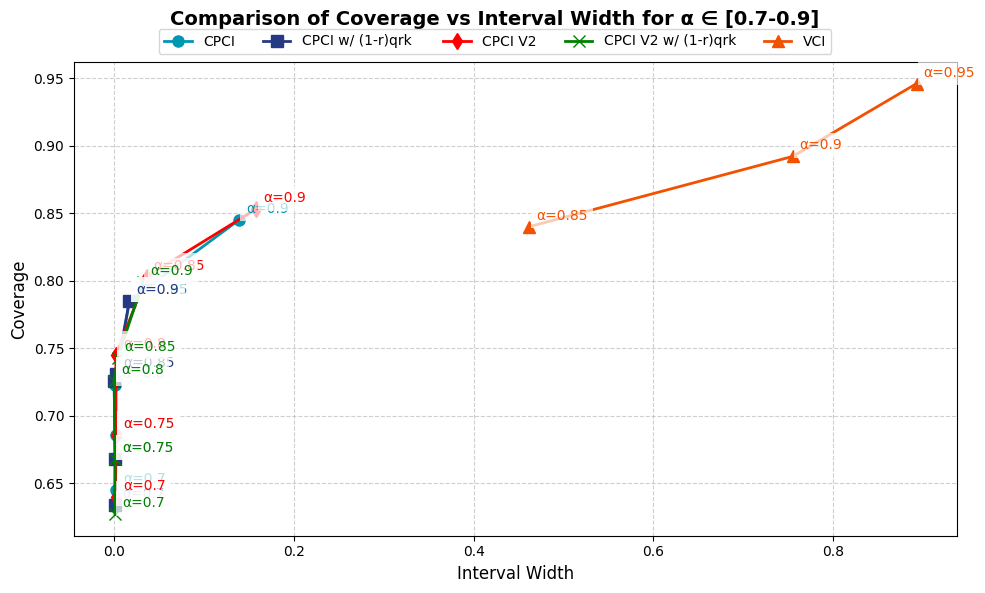

In [56]:
# Data for plotting
conformal_metrics_vanilla = {
    'alpha': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'coverage': [0.704, 0.744, 0.785, 0.84, 0.892, 0.946],
    'interval_width': [0.145, 0.206, 0.352, 0.462, 0.755, 0.893]
}

conformal_metrics_new = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.645, 0.686, 0.723, 0.785, 0.845],
    "interval_width": [0.002, 0.002, 0.001, 0.017, 0.139]
}
conformal_metrics_modified = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.634, 0.668, 0.726, 0.731, 0.785],
    "interval_width": [0.001, 0.001, 0.000, 0.002, 0.017]
}
conformal_metrics_new_v2 = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.640, 0.686, 0.745, 0.803, 0.853],
    "interval_width": [0.002, 0.002, 0.002, 0.036, 0.158]
}
conformal_metrics_modified_v2 = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.627, 0.668, 0.726, 0.743, 0.799],
    "interval_width": [0.001, 0.001, 0.000, 0.004, 0.032]
}
conformal_metrics_vanilla = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.840, 0.892, 0.946],
    "interval_width": [0.462, 0.755, 0.893]
}

conformal_metrics_last_v1_beta_tilde = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.807, 0.853, 0.923],
    "interval_width": [0.044, 0.158, 0.606]
}

conformal_metrics_combined_beta_tilde = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.803, 0.866, 0.925],
    "interval_width": [0.027, 0.202, 0.642]
}


fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Comparison of Coverage vs Interval Width for α ∈ [0.7-0.9]', fontsize=14, weight='bold')

# Plotting each method
methods = {
    "CPCI": ("#0097B2", "o", conformal_metrics_new),
    "CPCI w/ (1-r)qrk ": ("#263985", "s", conformal_metrics_modified),
    "CPCI V2": ("red", "d", conformal_metrics_new_v2),
    "CPCI V2 w/ (1-r)qrk": ("green", "x", conformal_metrics_modified_v2),
    "VCI": ("#F35000", "^", conformal_metrics_vanilla),
}

for label, (color, marker, data) in methods.items():
    ax.plot(data["interval_width"], data["coverage"], 
             marker=marker, color=color, linewidth=2, markersize=8, label=label)
    for i, alpha in enumerate(data["alpha"]):
        ax.annotate(f'α={alpha}',(data["interval_width"][i], data["coverage"][i]), xytext=(5, 5), textcoords='offset points', fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7), color=color)

# Add reference lines and shaded regions
# ax.axhline(y=0.8, linestyle='--', color='#B00000', linewidth=1.5, label='Target Coverage (80%)')
# ax.axhspan(0.8, 1.0, alpha=0.1, color='red', label='Target Coverage Zone')

# Customize plot
ax.set_xlabel('Interval Width', fontsize=12)
ax.set_ylabel('Coverage', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=10, bbox_to_anchor=(0.5, 0.96), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.savefig('conformal_comparison.png', transparent=True, bbox_inches='tight')
plt.show()

Keeping this plot because it's pretty

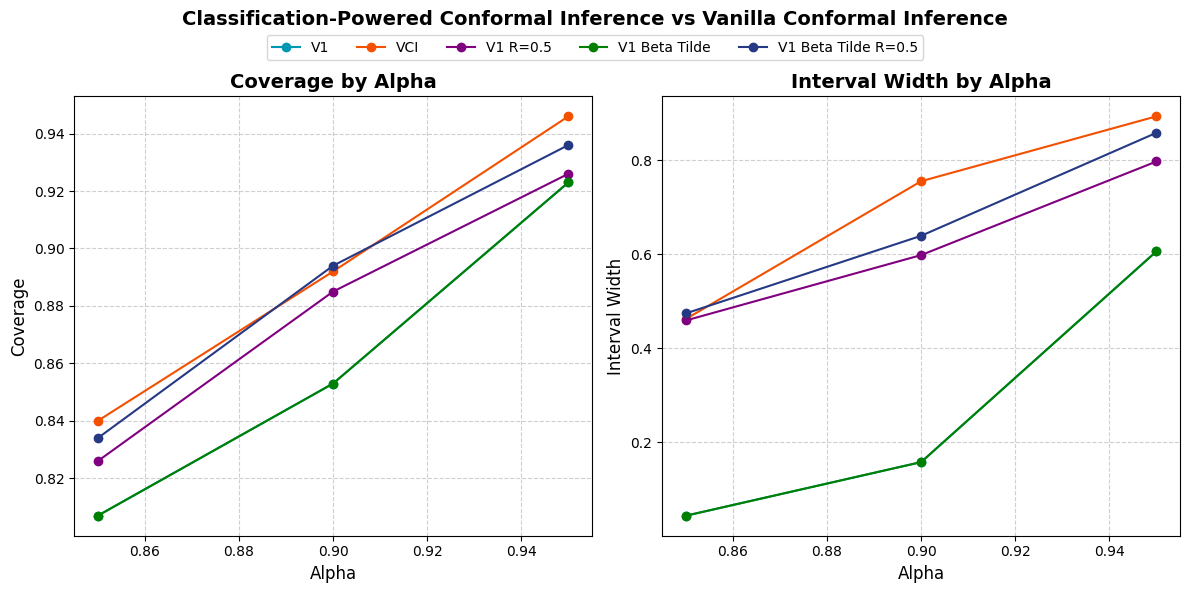

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Coverage line plot
for label, metrics, color in zip(
    ['V1', 'VCI', 'V1 R=0.5', 'V1 Beta Tilde', 'V1 Beta Tilde R=0.5'],
    [conformal_metrics_last_v1, conformal_metrics_vanilla,
     conformal_metrics_last_v1_r_05, conformal_metrics_last_v1_beta_tilde,
     conformal_metrics_last_v1_beta_tilde_r_05],
    ['#0097B2', '#F35000', 'purple', 'green', '#263985']
):
    ax[0].plot(metrics["alpha"], metrics["coverage"], marker='o', label=label, color=color)
# ax[0].plot([0.85, 0.95], [0.85, 0.95], linestyle='--', color='black', label='Desired Coverage')
ax[0].set_xlabel('Alpha', fontsize=12)
ax[0].set_ylabel('Coverage', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].set_title('Coverage by Alpha', fontsize=14, weight="bold")

# Interval Width line plot
for label, metrics, color in zip(
    ['V1', 'VCI', 'V1 R=0.5', 'V1 Beta Tilde', 'V1 Beta Tilde R=0.5'],
    [conformal_metrics_last_v1, conformal_metrics_vanilla,
     conformal_metrics_last_v1_r_05, conformal_metrics_last_v1_beta_tilde,
     conformal_metrics_last_v1_beta_tilde_r_05],
    ['#0097B2', '#F35000', 'purple', 'green', '#263985']
):
    ax[1].plot(metrics["alpha"], metrics["interval_width"], marker='o', label=label, color=color)

ax[1].set_xlabel('Alpha', fontsize=12)
ax[1].set_ylabel('Interval Width', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].set_title('Interval Width by Alpha', fontsize=14, weight="bold")

# Adjust layout
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=10, bbox_to_anchor=(0.5, 0.95), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9]) 
fig.suptitle('Classification-Powered Conformal Inference vs Vanilla Conformal Inference', fontsize=14, weight='bold')
plt.show()

Figure Used for ICML Paper

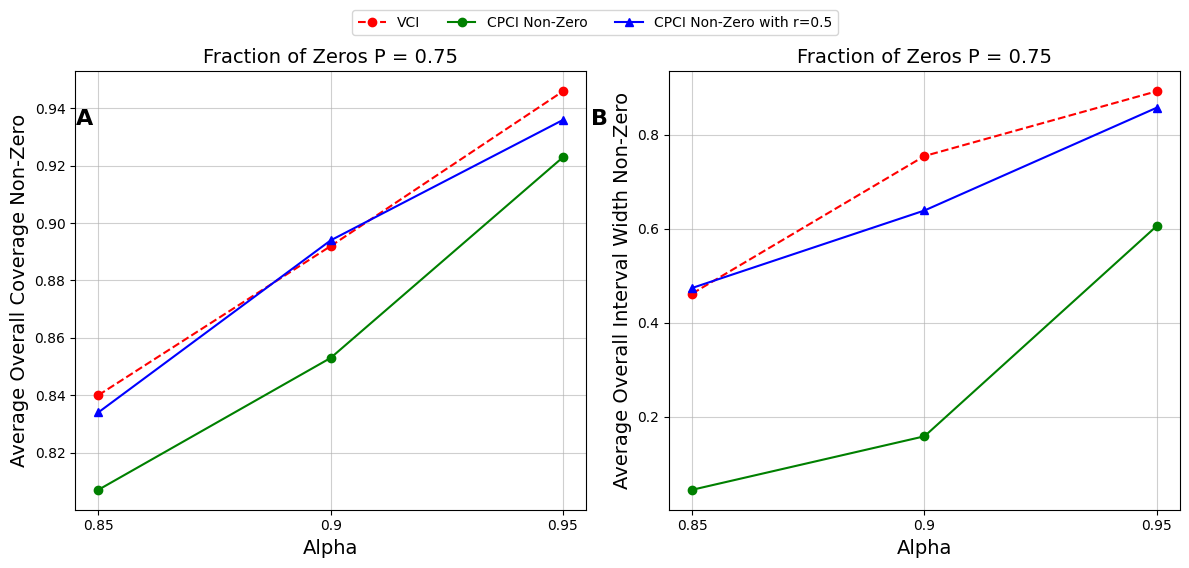

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Define the custom x-ticks
x_ticks = [0.85, 0.9, 0.95]

ax[0].plot(conformal_metrics_vanilla["alpha"], conformal_metrics_vanilla["coverage"], marker='o', label='VCI', color='red', linestyle='--')
ax[0].plot(conformal_metrics_last_v1_beta_tilde["alpha"], conformal_metrics_last_v1_beta_tilde["coverage"], marker='o', label='CPCI Non-Zero', color='green')
ax[0].plot(conformal_metrics_last_v1_beta_tilde_r_05["alpha"], conformal_metrics_last_v1_beta_tilde_r_05["coverage"], marker='^', label='CPCI Non-Zero with r=0.5', color='blue')
# ax[0].plot(conformal_metrics_non_zero_beta_tilde["alpha"], conformal_metrics_non_zero_beta_tilde["coverage"], marker='p', label='Non Zero', color='yellow')
# ax[0].plot(conformal_metrics_non_zero_beta_tilde_r05["alpha"], conformal_metrics_non_zero_beta_tilde_r05["coverage"], marker='*', label='Non Zero with r=0.5', color='purple')

# Add desired coverage line
# ax[0].plot([0.85, 0.95], [0.85, 0.95], linestyle='--', color='red', label='Desired Coverage')

ax[0].set_xticks(x_ticks)  # Set custom x-ticks
ax[0].set_xticklabels(x_ticks)  # Set custom x-tick labels
ax[0].set_xlabel('Alpha', fontsize=14)
ax[0].set_ylabel('Average Overall Coverage Non-Zero', fontsize=14)
ax[0].grid(True, alpha=0.6)
ax[0].set_title('Fraction of Zeros P = 0.75', fontsize=14)

# Interval Width line plot
ax[1].plot(conformal_metrics_vanilla["alpha"], conformal_metrics_vanilla["interval_width"], marker='o', label='VCI', color='red', linestyle='--')
ax[1].plot(conformal_metrics_last_v1_beta_tilde["alpha"], conformal_metrics_last_v1_beta_tilde["interval_width"], marker='o', label='CPCI Non-Zero', color='green')
ax[1].plot(conformal_metrics_last_v1_beta_tilde_r_05["alpha"], conformal_metrics_last_v1_beta_tilde_r_05["interval_width"], marker='^', label='CPCI Non-Zero with r=0.5', color='blue')
# ax[1].plot(conformal_metrics_non_zero_beta_tilde["alpha"], conformal_metrics_non_zero_beta_tilde["interval_width"], marker='p', label='Non Zero', color='yellow')
# ax[1].plot(conformal_metrics_non_zero_beta_tilde_r05["alpha"], conformal_metrics_non_zero_beta_tilde_r05["interval_width"], marker='*', label='Non Zero with r=0.5', color='purple')

ax[1].set_xticks(x_ticks)  # Set custom x-ticks
ax[1].set_xticklabels(x_ticks)  # Set custom x-tick labels
ax[1].set_xlabel('Alpha', fontsize=14)
ax[1].set_ylabel('Average Overall Interval Width Non-Zero', fontsize=14)
ax[1].grid(True, alpha=0.6)
ax[1].set_title('Fraction of Zeros P = 0.75', fontsize=14)
ax[0].text(0.035, 0.915, 'A', transform=ax[0].transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax[1].text(-0.120, 0.915, 'B', transform=ax[1].transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=10, bbox_to_anchor=(0.5, 0.95), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9]) 
# fig.suptitle('Conformal Comparison', fontsize=14, weight='bold')
# plt.savefig('comparison_nonzero.png', transparent=True, bbox_inches='tight')
plt.show()

In [55]:
width = 0.4  # Adjusted bar width
x = np.arange(len(conformal_metrics_new["alpha"]))

# Compute differences
diff_coverage = (np.array(conformal_metrics_vanilla["coverage"]) - np.array(conformal_metrics_new["coverage"])) / np.array(conformal_metrics_vanilla["coverage"]) * 100
diff_interval = (np.array(conformal_metrics_vanilla["interval_width"]) - np.array(conformal_metrics_new["interval_width"])) / np.array(conformal_metrics_vanilla["interval_width"]) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Classification-Powered Conformal Inference vs Vanilla Conformal Inference', fontsize=16, weight='bold')

# Coverage Comparison
bar1 = ax1.bar(x - width, conformal_metrics_new["coverage"], width, label='CPCI', color='#0097B2')
bar2 = ax1.bar(x, conformal_metrics_vanilla["coverage"], width, label='VCI', color='#F35000')

def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

add_value_labels(bar1, ax1)
add_value_labels(bar2, ax1)

# Set y-axis limits with padding for annotations
max_coverage = max(max(conformal_metrics_new["coverage"]), max(conformal_metrics_vanilla["coverage"]))
ax1.set_ylim(0, max_coverage * 1.15)  # Add 15% padding

ax1.set_xticks(x)
ax1.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new["alpha"]])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Interval Width Comparison
bar3 = ax2.bar(x - width, conformal_metrics_new["interval_width"], width, color='#0097B2')
bar4 = ax2.bar(x, conformal_metrics_vanilla["interval_width"], width, color='#F35000')

add_value_labels(bar3, ax2)
add_value_labels(bar4, ax2)

# Set y-axis limits with padding for annotations
max_interval = max(max(conformal_metrics_new["interval_width"]), max(conformal_metrics_vanilla["interval_width"]))
ax2.set_ylim(0, max_interval * 1.15)  # Add 15% padding

ax2.set_xticks(x)
ax2.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new["alpha"]])

ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.set_title('Interval Width Comparison', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Define annotation properties
bbox_props = dict(boxstyle="round,pad=0.3", fc='#C8E6C9', ec="none", alpha=0.6)

for i, (diff_cov, diff_int) in enumerate(zip(diff_coverage, diff_interval)):
    # Coverage reduction
    max_cov = max(conformal_metrics_new["coverage"][i], conformal_metrics_vanilla["coverage"][i])
    annotation_height_cov = max_cov + (max_coverage * 0.07)  # Position at 3% above the bar
    
    if diff_cov > 0:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↓{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↑{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)

    # Interval width reduction
    max_int = max(conformal_metrics_new["interval_width"][i], conformal_metrics_vanilla["interval_width"][i])
    annotation_height_int = max_int + (max_interval * 0.07)  # Position at 3% above the bar
    
    if diff_int > 0:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↓{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↑{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)
        
# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('CPCI_vs_VCI.png', transparent=True, bbox_inches='tight')
plt.show()

NameError: name 'conformal_metrics_new' is not defined

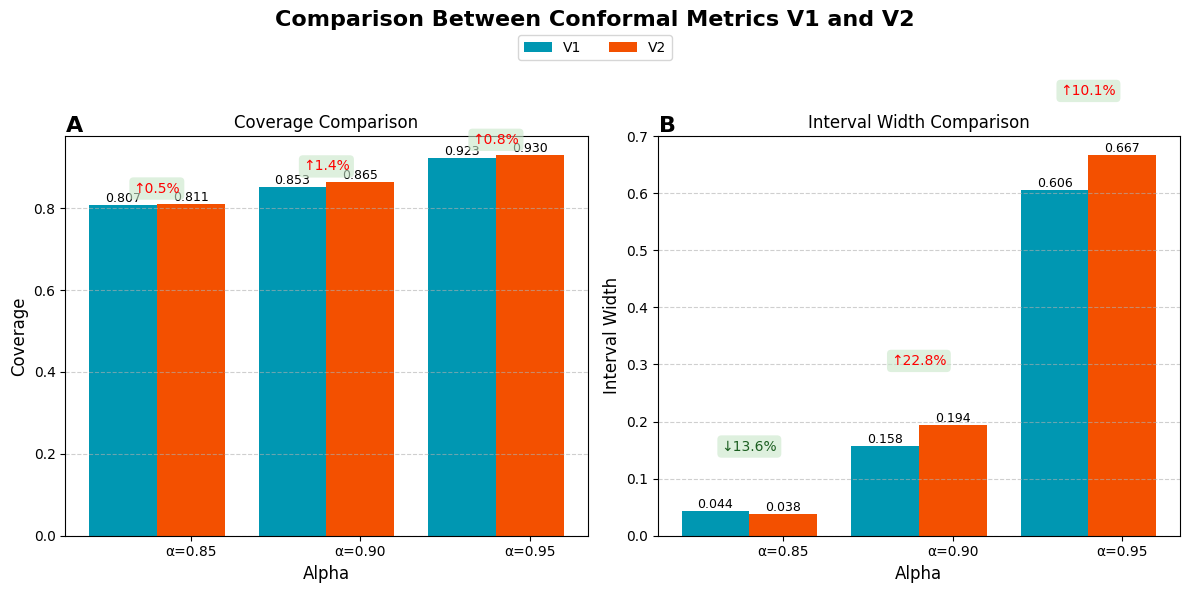

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Data
conformal_metrics_last_v1 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.807, 0.853, 0.923],
    "interval_width": [0.044, 0.158, 0.606]
}
conformal_metrics_last_v2 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.786, 0.908, 0.954],
    "interval_width": [0.012, 1.509, 1.767]
}

# Bar width and x-axis positions
width = 0.4
x = np.arange(len(conformal_metrics_last_v1_beta_tilde["alpha"]))

# Compute percentage differences
diff_coverage = (np.array(conformal_metrics_last_v1_beta_tilde["coverage"]) - np.array(conformal_metrics_last_v2_beta_tilde["coverage"])) / np.array(conformal_metrics_last_v1_beta_tilde["coverage"]) * 100
diff_interval = (np.array(conformal_metrics_last_v1_beta_tilde["interval_width"]) - np.array(conformal_metrics_last_v2_beta_tilde["interval_width"])) / np.array(conformal_metrics_last_v1_beta_tilde["interval_width"]) * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison Between Conformal Metrics V1 and V2', fontsize=16, weight='bold')

# Coverage Comparison
bar1 = ax1.bar(x - width, conformal_metrics_last_v1_beta_tilde["coverage"], width, label='V1', color='#0097B2')
bar2 = ax1.bar(x, conformal_metrics_last_v2_beta_tilde["coverage"], width, label='V2', color='#F35000')

# Interval Width Comparison
bar3 = ax2.bar(x - width, conformal_metrics_last_v1_beta_tilde["interval_width"], width, label='V1', color='#0097B2')
bar4 = ax2.bar(x, conformal_metrics_last_v2_beta_tilde["interval_width"], width, label='V2', color='#F35000')

# Add value labels
def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

add_value_labels(bar1, ax1)
add_value_labels(bar2, ax1)
add_value_labels(bar3, ax2)
add_value_labels(bar4, ax2)

# Annotate percentage differences
bbox_props = dict(boxstyle="round,pad=0.3", fc='#C8E6C9', ec="none", alpha=0.6)

for i, (diff_cov, diff_int) in enumerate(zip(diff_coverage, diff_interval)):
    # Coverage annotations
    max_cov = max(conformal_metrics_last_v1_beta_tilde["coverage"][i], conformal_metrics_last_v2_beta_tilde["coverage"][i])
    annotation_height_cov = max_cov + 0.02  # Slightly above the highest bar
    ax1.text(x[i] - width/2, annotation_height_cov, f'↓{abs(diff_cov):.1f}%' if diff_cov > 0 else f'↑{abs(diff_cov):.1f}%',
             ha='center', va='bottom', fontsize=10, color='#1B5E20' if diff_cov > 0 else 'red', bbox=bbox_props)

    # Interval annotations
    max_int = max(conformal_metrics_last_v1_beta_tilde["interval_width"][i], conformal_metrics_last_v2_beta_tilde["interval_width"][i])
    annotation_height_int = max_int + 0.1  # Slightly above the highest bar
    ax2.text(x[i] - width/2, annotation_height_int, f'↓{abs(diff_int):.1f}%' if diff_int > 0 else f'↑{abs(diff_int):.1f}%',
             ha='center', va='bottom', fontsize=10, color='#1B5E20' if diff_int > 0 else 'red', bbox=bbox_props)

# Axis labels and titles
ax1.set_xticks(x)
ax1.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_last_v1_beta_tilde["alpha"]])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2.set_xticks(x)
ax2.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_last_v1_beta_tilde["alpha"]])
ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.set_title('Interval Width Comparison', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Add legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10, bbox_to_anchor=(0.5, 0.95), frameon=True)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Conformal_Metrics_V1_vs_V2.png', transparent=True, bbox_inches='tight')
plt.show()

Vanilla Conformal


Coverage: 0.892
Average interval width: 0.755


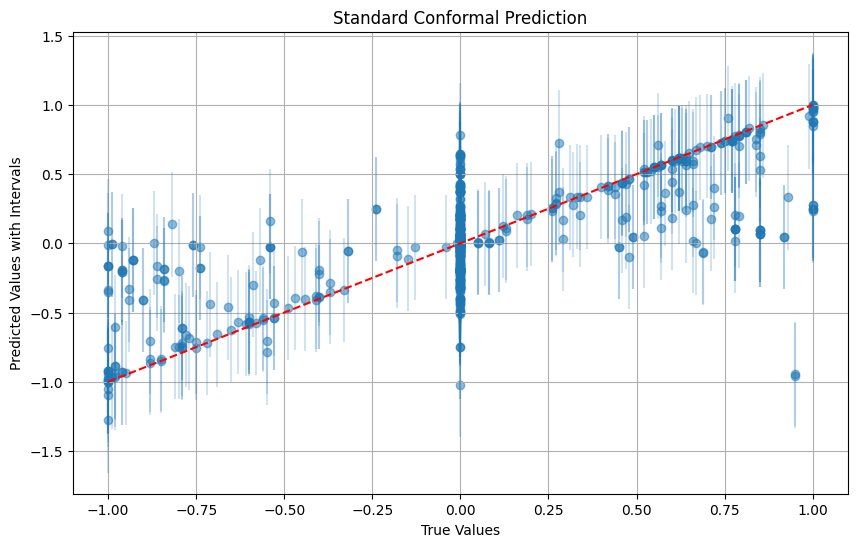

In [237]:
def vanilla_conformal_prediction(X_train, y_train, X_calib, y_calib, X_test, alpha=0.9):
    """
    Basic conformal prediction implementation.
    
    Parameters:
    -----------
    X_train : Training features
    y_train : Training target
    X_calib : Calibration features
    y_calib : Calibration target
    X_test : Test features
    alpha : Target coverage level (default 0.9 for 90% coverage)
    
    Returns:
    --------
    lower_bound, upper_bound : Prediction intervals for test set
    """
    # 1. Train the model on training data
    model = xgb.XGBRegressor(**regression_params_short)
    model.fit(X_train, y_train)
    
    # 2. Calculate nonconformity scores on calibration set
    calib_preds = model.predict(X_calib)
    nonconformity_scores = np.abs(y_calib - calib_preds)
    
    # 3. Find the quantile corresponding to desired coverage
    quantile = np.quantile(nonconformity_scores, alpha)
    
    # 4. Make predictions on test set
    test_preds = model.predict(X_test)
    
    # 5. Create prediction intervals
    lower_bound = test_preds - quantile
    upper_bound = test_preds + quantile
    
    return lower_bound, upper_bound

# Usage example:
# First split data into train, calibration, and test
X_train, X_temp, y_train, y_temp = train_test_split(X, normalized_pctg_change, test_size=0.4, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Get prediction intervals
lower, upper = vanilla_conformal_prediction(
    X_train, y_train,
    X_calib, y_calib,
    X_test,
    alpha=0.9
)

# Calculate coverage
coverage = np.mean((y_test >= lower) & (y_test <= upper))
interval_width = np.mean(upper - lower)

print(f"Coverage: {coverage:.3f}")
print(f"Average interval width: {interval_width:.3f}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, (upper + lower)/2, alpha=0.5)
plt.errorbar(y_test, (upper + lower)/2, 
            yerr=(upper - lower)/2, 
            fmt='none', alpha=0.2)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         '--', color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values with Intervals')
plt.title('Standard Conformal Prediction')
plt.grid(True)
plt.show()